# Disaster Tweets Dataset From kaggle Competition 

In [0]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [0]:
# load data set
train = pd.read_csv('/content/drive/My Drive/Dataset/NLP/Disaster Tweets/train.csv')
test = pd.read_csv('/content/drive/My Drive/Dataset/NLP/Disaster Tweets/test.csv')
sample_subm = pd.read_csv('/content/drive/My Drive/Dataset/NLP/Disaster Tweets/sample_submission.csv')

In [4]:
print(train.shape)
print(test.shape)

(7613, 5)
(3263, 4)


0    0.57034
1    0.42966
Name: target, dtype: float64


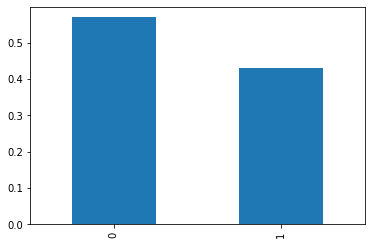

In [4]:
train.target.value_counts(normalize=True).plot(kind='bar')
print(train.target.value_counts(normalize=True))

In [5]:
train.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [6]:
print('True example :\n', train[train.target==1].text.head(1))
print(train.text[0])
print('False example :\n', train[train.target==0].text.head(3))

True example :
 0    Our Deeds are the Reason of this #earthquake M...
Name: text, dtype: object
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
False example :
 15      What's up man?
16       I love fruits
17    Summer is lovely
Name: text, dtype: object


In [0]:
# we only use text feature
train_text = train.text
validation = test.text # validationset for submission

In [0]:
training = train_text[:7500]
testing = train_text[7500:]

train_label = np.array(train.target[:7500])
test_label = np.array(train.target[7500:])

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
# Tokenize word on texts
vocab_size = 20000
#max_length = 30

#make token from trining set
token = Tokenizer(vocab_size, oov_token='<unknown>')
token.fit_on_texts(training)
word_index = token.word_index

training_seq = token.texts_to_sequences(training)
test_seq = token.texts_to_sequences(testing)

length = []
for i in range(len(training_seq)):
  temp = len(training_seq[i])
  length.append(temp)
max_length = max(length)

training_final = pad_sequences(training_seq, maxlen=max_length, padding='post', truncating='post')
test_final = pad_sequences(test_seq, maxlen= max_length, padding='post', truncating='post')

In [18]:
model = tf.keras.Sequential([
                            tf.keras.layers.Embedding(vocab_size,64, input_length= max_length),
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(248, activation='relu'),
                            tf.keras.layers.Dense(124,activation='relu'),
                            tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 33, 64)            1280000   
_________________________________________________________________
flatten (Flatten)            (None, 2112)              0         
_________________________________________________________________
dense (Dense)                (None, 248)               524024    
_________________________________________________________________
dense_1 (Dense)              (None, 124)               30876     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 125       
Total params: 1,835,025
Trainable params: 1,835,025
Non-trainable params: 0
_________________________________________________________________


In [19]:
import datetime as dt
start = dt.datetime.today()

history = model.fit(training_final, train_label, epochs=20, validation_data=(test_final,test_label), verbose=1)

finish = dt.datetime.today()
print('Process time took :', finish-start)

Epoch 1/20
235/235 [==============================] - 4s 19ms/step - loss: 0.5411 - accuracy: 0.7271 - val_loss: 0.2505 - val_accuracy: 0.9027
Epoch 2/20
235/235 [==============================] - 4s 18ms/step - loss: 0.2174 - accuracy: 0.9221 - val_loss: 0.1967 - val_accuracy: 0.9292
Epoch 3/20
235/235 [==============================] - 4s 18ms/step - loss: 0.0728 - accuracy: 0.9748 - val_loss: 0.2021 - val_accuracy: 0.9292
Epoch 4/20
235/235 [==============================] - 4s 18ms/step - loss: 0.0367 - accuracy: 0.9849 - val_loss: 0.2131 - val_accuracy: 0.9292
Epoch 5/20
235/235 [==============================] - 5s 19ms/step - loss: 0.0221 - accuracy: 0.9901 - val_loss: 0.2409 - val_accuracy: 0.9381
Epoch 6/20
235/235 [==============================] - 5s 20ms/step - loss: 0.0161 - accuracy: 0.9924 - val_loss: 0.2359 - val_accuracy: 0.9469
Epoch 7/20
235/235 [==============================] - 5s 21ms/step - loss: 0.0144 - accuracy: 0.9929 - val_loss: 0.3053 - val_accuracy: 0.9381

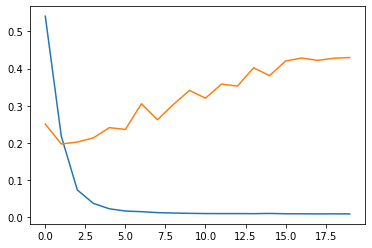

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

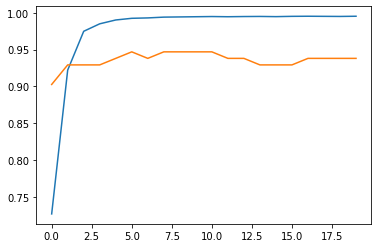

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [22]:
model.evaluate(training_final, train_label)

235/235 [==============================] - 1s 3ms/step - loss: 0.0079 - accuracy: 0.9953


[0.00791651289910078, 0.9953333139419556]

In [23]:
model.evaluate(test_final,test_label)

4/4 [==============================] - 0s 4ms/step - loss: 0.4298 - accuracy: 0.9381


[0.4297542870044708, 0.9380530714988708]

> it seems overfitting

In [0]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [0]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(10000, 32)


In [0]:
import io
vector = io.open("vecs.tsv", 'w', encoding= 'utf-8')
meta = io.open('meta.tsv', 'w',encoding='utf-8')
for word_num in range (1,vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  meta.write(word + '\n')
  vector.write('\t'.join([str(x) for x in embeddings])+ '\n')

vector.close()
meta.close()

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

## + LSTM Layer

In [73]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size, 64, input_length= max_length),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                             tf.keras.layers.Dense(124, activation='relu'),
                             tf.keras.layers.Dense(1,activation='sigmoid')
])
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 64)            640000    
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 128)           66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 124)               8060      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 125       
Total params: 755,449
Trainable params: 755,449
Non-trainable params: 0
_________________________________________________________________


In [74]:
start = dt.datetime.today()

model.fit(training_final, train_label, epochs=20, validation_data=(test_final,test_label), verbose=0)

finish = dt.datetime.today()

print('Process time took :', finish- start)

Process time took : 0:02:42.870407


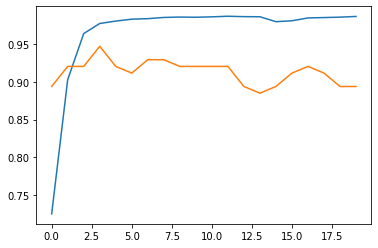

In [64]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [75]:
model.evaluate(test_final,test_label)

4/4 [==============================] - 0s 10ms/step - loss: 0.6551 - accuracy: 0.9381


[0.6551049947738647, 0.9380530714988708]

## + Convolution layer

In [159]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size, 32, input_length= max_length),
                             tf.keras.layers.Conv1D(128,5, activation='relu'),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(256, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')
                            
])

model.summmary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 64)            640000    
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 128)           66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 124)               8060      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 125       
Total params: 755,449
Trainable params: 755,449
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(training_final, train_label, epochs=20, validation_data=(test_final,test_label))

In [68]:
model.evaluate(test_final,test_label)

4/4 [==============================] - 0s 3ms/step - loss: 0.6155 - accuracy: 0.9204


[0.6155024766921997, 0.9203540086746216]

## Final Model

In [0]:
token.fit_on_texts(train.text)

train_seq = token.texts_to_sequences(train.text)
train_padded = pad_sequences(train_seq, maxlen=max_length, padding='post', truncating='post')

label = np.array(train.target)

In [172]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size, 64, input_length= max_length),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                             tf.keras.layers.Dense(124, activation='relu'),
                             tf.keras.layers.Dense(1,activation='sigmoid')
])
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 64)            1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 128)           66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 124)               8060      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 125       
Total params: 1,395,449
Trainable params: 1,395,449
Non-trainable params: 0
_________________________________________________________________


In [173]:
history = model.fit(train_padded,label, epochs=10)

Epoch 1/10
238/238 [==============================] - 10s 42ms/step - loss: 0.5130 - accuracy: 0.7482
Epoch 2/10
238/238 [==============================] - 10s 41ms/step - loss: 0.2877 - accuracy: 0.8870
Epoch 3/10
238/238 [==============================] - 10s 41ms/step - loss: 0.1538 - accuracy: 0.9448
Epoch 4/10
238/238 [==============================] - 10s 41ms/step - loss: 0.0892 - accuracy: 0.9710
Epoch 5/10
238/238 [==============================] - 10s 41ms/step - loss: 0.0513 - accuracy: 0.9828
Epoch 6/10
238/238 [==============================] - 10s 41ms/step - loss: 0.0383 - accuracy: 0.9856
Epoch 7/10
238/238 [==============================] - 10s 41ms/step - loss: 0.0241 - accuracy: 0.9899
Epoch 8/10
238/238 [==============================] - 10s 41ms/step - loss: 0.0183 - accuracy: 0.9916
Epoch 9/10
238/238 [==============================] - 10s 40ms/step - loss: 0.0198 - accuracy: 0.9909
Epoch 10/10
238/238 [==============================] - 10s 41ms/step - loss: 0.020

## Prediction

In [107]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [0]:
sequences = token.texts_to_sequences(test.text)

In [0]:
padded_seq = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

In [0]:
prediction = np.round(model.predict(padded_seq)).astype(int)

In [0]:
prediction = prediction.reshape(prediction.shape[0])

In [0]:
final = pd.DataFrame({'id': test.id, 'target': prediction})

In [177]:
final.head()

,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,0


In [129]:
sample_subm.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [0]:
final.to_csv('submission2.csv', index=False)

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('submission2.csv')